<a href="https://colab.research.google.com/github/MSR806/DL_concrete_strength/blob/main/Compressive_Strength_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing

#--------#--------#---------#---------#

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1owoMOYIg1oxxDL25iAFYZ9v3CebT4vay'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
downloaded.GetContentFile('Concrete_Data_Yeh (1).csv')

#**Importing data**

In [ ]:
!ls

 2.png	 adc.json  'Concrete_Data_Yeh (1).csv'	 sample_data


In [ ]:
df = pd.read_csv('Concrete_Data_Yeh (1).csv')

In [ ]:
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.tail()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


In [ ]:
len(df)

1030

In [ ]:
df.shape

(1030, 9)

In [ ]:
df.loc[3]

cement              332.50
slag                142.50
flyash                0.00
water               228.00
superplasticizer      0.00
coarseaggregate     932.00
fineaggregate       594.00
age                 365.00
csMPa                41.05
Name: 3, dtype: float64

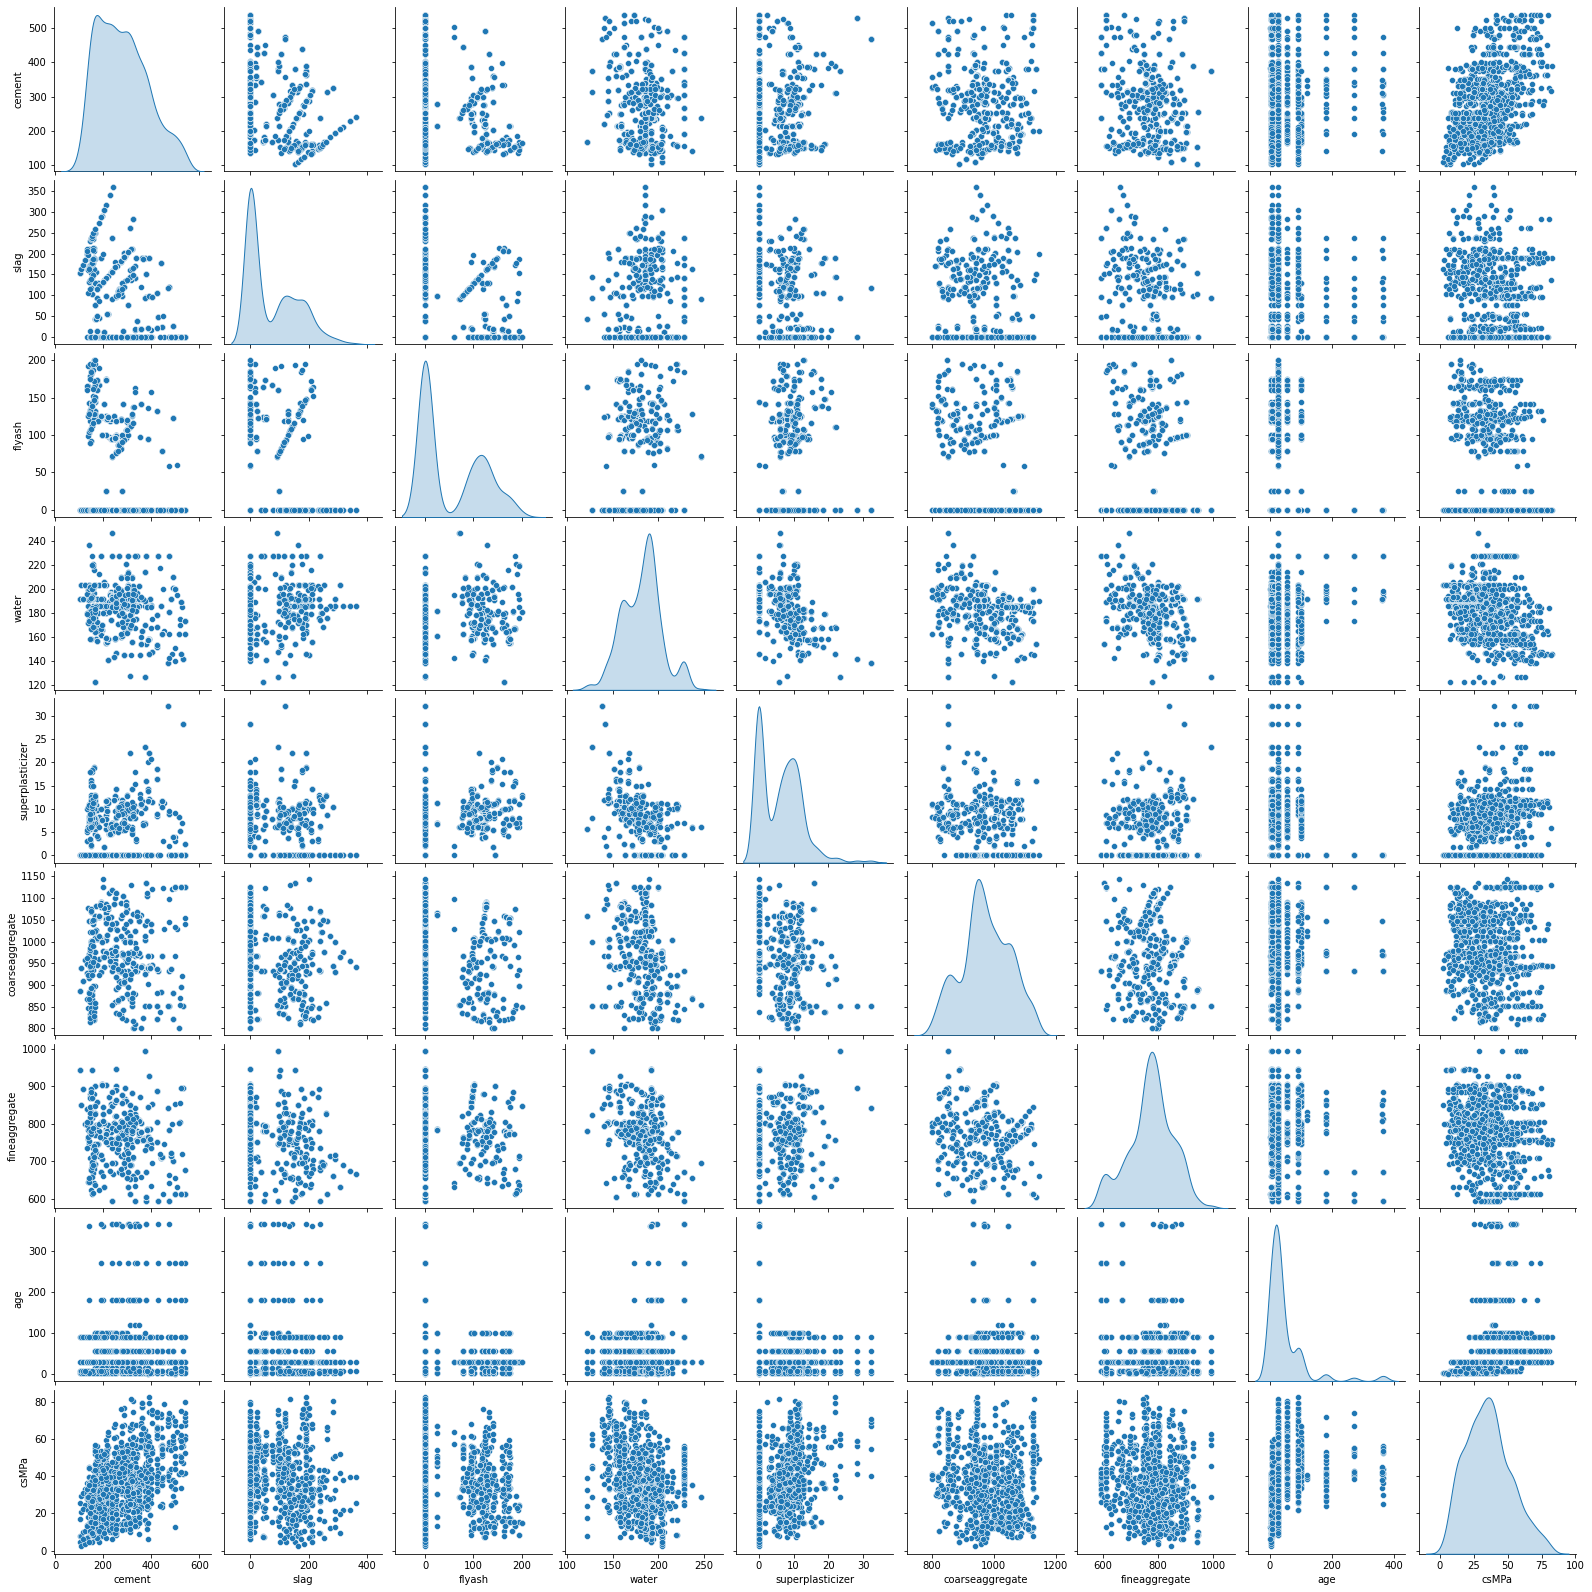

In [ ]:
sns.pairplot(df,palette="husl",diag_kind="kde")
plt.savefig('2.png')

In [ ]:
data = df.to_numpy()

In [ ]:
classes = df.columns.values

In [ ]:
print(type(data), type(classes))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
print(data.shape, classes.shape)

(1030, 9) (9,)


#**Preprocessing data**

In [ ]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler = MinMaxScaler()

# fit scaler on data
scaler.fit(data,)

# apply transform
norm_data = scaler.transform(data)
#norm_data = data

# inverse transform
#inverse = scaler.inverse_transform(normalized)

In [ ]:
labels = norm_data[:, 8]
norm_data = norm_data[:, 0:8]

In [ ]:
print(norm_data.shape, labels.shape)

(1030, 8) (1030,)


In [ ]:
torch.manual_seed(0)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(norm_data, labels, random_state= 5)
print(X_train.shape, Y_train.shape, norm_data.shape, labels.shape)

(772, 8) (772,) (1030, 8) (1030,)


#**Using PyTorch**

In [ ]:
X_train, X_val, Y_train, Y_val = map(torch.tensor, (X_train, X_val, Y_train, Y_val))

In [ ]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

torch.Size([772, 8]) torch.Size([258, 8]) torch.Size([772]) torch.Size([258])


In [ ]:
class FFNetwork(nn.Module):
  def __init__(self):
    super(FFNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(8, 64),    # (N, 8) --> (N, 64)
        nn.ReLU(),
        nn.Linear(64, 32),    # (N, 64) --> (N, 32)
        nn.ReLU(),
        nn.Linear(32,1)        # (N, 32)  --> (N, 1)
    )

  def fwd(self, x):
    return self.net(x)

In [ ]:
def fit(x, y, x_val, y_val, opt, loss_fn, epochs = 1000):
  train_loss_arr = []
  test_loss_arr = []
  for epoch in range(epochs):
    y_hat = fn.fwd(x)
    loss = loss_fn(y_hat, y)
    train_loss_arr.append(loss.item())
    test_loss_arr.append(loss_fn(fn.fwd(x_val), y_val).item())

    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch%10 ==0:
      print('Epoch: %d/%d, Train loss: %0.5f, Test loss: %0.5f' %(epoch,epochs, loss, loss_fn(fn.fwd(x_val), y_val)))
  plt.plot(train_loss_arr, 'r-', label='Train Loss')
  plt.plot(test_loss_arr, 'b-', label='Test Loss')
  plt.legend(loc="upper right")
  plt.xlabel('Epochs')
  plt.ylabel('MSE loss')
  plt.show()
  plt.savefig('loss.png')
  return loss.item()

Epoch: 0/500, Train loss: 0.13685, Test loss: 0.12142
Epoch: 10/500, Train loss: 0.12796, Test loss: 0.11286
Epoch: 20/500, Train loss: 0.11969, Test loss: 0.10496
Epoch: 30/500, Train loss: 0.11197, Test loss: 0.09756
Epoch: 40/500, Train loss: 0.10447, Test loss: 0.09035
Epoch: 50/500, Train loss: 0.09700, Test loss: 0.08324
Epoch: 60/500, Train loss: 0.08982, Test loss: 0.07649
Epoch: 70/500, Train loss: 0.08310, Test loss: 0.07019
Epoch: 80/500, Train loss: 0.07688, Test loss: 0.06440
Epoch: 90/500, Train loss: 0.07107, Test loss: 0.05904
Epoch: 100/500, Train loss: 0.06561, Test loss: 0.05409
Epoch: 110/500, Train loss: 0.06075, Test loss: 0.04975
Epoch: 120/500, Train loss: 0.05669, Test loss: 0.04621
Epoch: 130/500, Train loss: 0.05347, Test loss: 0.04347
Epoch: 140/500, Train loss: 0.05102, Test loss: 0.04147
Epoch: 150/500, Train loss: 0.04922, Test loss: 0.04008
Epoch: 160/500, Train loss: 0.04798, Test loss: 0.03918
Epoch: 170/500, Train loss: 0.04715, Test loss: 0.03864
Epo

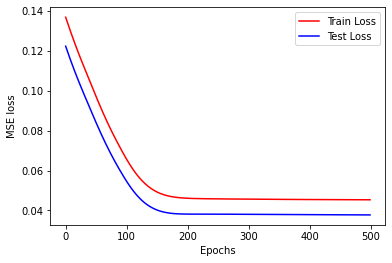

0.04534778371453285

<Figure size 432x288 with 0 Axes>

In [ ]:
fn = FFNetwork()
loss_fn = nn.MSELoss(reduction = 'mean')
opt = optim.Adam(fn.parameters(), lr = 0.0001)
X_train = X_train.float()
Y_train = Y_train.float()
X_val = X_val.float()
Y_val = Y_val.float()
#out = fn.fwd(X_train)
#print(loss_fn(fn.fwd(X_train), Y_train).item())
fit(X_train, Y_train, X_val, Y_val, opt, loss_fn, epochs=500)

In [ ]:
print(loss_fn(fn.fwd(X_val), Y_val))

tensor(0.0384, grad_fn=<MseLossBackward>)
